In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
import astropy.units as u
from astropy.visualization import simple_norm
from astropy.table import QTable
from astropy.coordinates import SkyCoord

from photutils.aperture import CircularAperture, CircularAnnulus

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats

# specific functions for this work
from helpers import get_aper_flux, disp_subimages, coords_from_mosaic

Source details

In [2]:
sourcecoords = "21:32:16.01  +00:15:14.3"   # nominal source location
sourcename = "lds749b"
aorid = "r28812544"
#aprads = [3.0, 3.0, 7.0]  # source radius, sky inner/outer radii
#apcors = [1.125, 1.120, 1.135, 1.221]
aprads = [3.0, 12.0, 20.0]  # source radius, sky inner/outer radii
apcors = [1.123, 1.112, 1.118, 1.213]

Determine the source position based on default coordinates and centroiding on nearest source

ch1 323.06866487748596 0.2541091629704663
ch2 323.0686595979125 0.254057643924993
ch3 323.0686059177013 0.2541339897233813
ch4 323.06863990345664 0.25407893939010456
<SkyCoord (ICRS): (ra, dec) in deg
    (323.06866224, 0.2540834)>


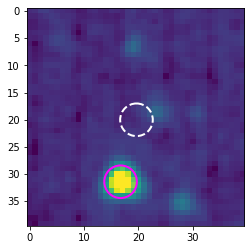

In [3]:
centers = []
for i in np.arange(1,5):
    mosfilename = glob.glob(f"data/{sourcename}/{aorid}/ch{i}/pbcd/SPITZER_I{i}_*_maic.fits")[0]
    new_center = coords_from_mosaic(sourcecoords, mosfilename, show_image=(i==1))
    centers.append(new_center)
    print(f"ch{i}", new_center.ra.degree, new_center.dec.degree)

# average the coordinates from ch1 and ch2
center_ra = 0.5 * (centers[0].ra + centers[1].ra)
center_dec = 0.5 * (centers[0].dec + centers[1].dec)
new_center = SkyCoord(center_ra, center_dec)
print(new_center)

Perform aperture photometry and display cutouts with the apertures used

In [4]:
import copy

allchfiles = [np.sort(glob.glob(f"data/{sourcename}/{aorid}/ch{i}/bcd/SPITZER_I{i}_*_cbcd.fits")) for i in np.arange(1, 5)]

chsfluxes = []
chscorfacs1 = []
chscorfacs2 = []
chsfiles = []
chsx = []
chsy = []
medbkgs = []
totbkgs = []
for k, allfiles in enumerate(allchfiles):
    sfluxes = []
    corfac1 = []
    corfac2 = []
    medbkg = []
    totbkg = []
    files = []
    x = []
    y = []
    for cfilename in allfiles:
        hdul = fits.open(cfilename)
        image = copy.copy(hdul[0].data)
        w = wcs.WCS(hdul[0].header)

        # pixscales = np.absolute([hdul[0].header["PXSCAL1"], hdul[0].header["PXSCAL2"]]) / 3600.
        # pix_area_sr = (pixscales[0]*pixscales[1])*((np.pi/180.0))**2
        pix_area_sr = w.proj_plane_pixel_area().to(u.sr).value
        conv_fac = 1e9*pix_area_sr  # convert from MJy/sr to mJy/pixel  
        image *= conv_fac

        if cfilename == "data/lds749b/r28812544/ch4/bcd/SPITZER_I4_28812544_0001_0000_5_cbcd.fits":
            print("diagnoistics")
            print(conv_fac, pix_area_sr)
            print(image[51, 121:137])
            print(hdul[0].data[51, 121:137])
        
        center_pix = new_center.to_pixel(w)
        isize = image.shape
        if (0 < center_pix[0] < isize[0]) & (0 < center_pix[1] < isize[1]):
            aperture = CircularAperture(center_pix, r=aprads[0])
            annulus_aperture = CircularAnnulus(center_pix, r_in=aprads[1], r_out=aprads[2])
            if cfilename == "data/lds749b/r28812544/ch4/bcd/SPITZER_I4_28812544_0001_0000_5_cbcd.fits":
                for zz in range(1, 6, 1):
                    tflux = get_aper_flux(image, aperture, annulus_aperture, center_pix, k, bkg_max_iter=zz)
                    print(zz, tflux[0]*apcors[k], tflux[3], tflux[4]*apcors[k]*tflux[1]*tflux[2], tflux[5], tflux[6])
            cflux = get_aper_flux(image, aperture, annulus_aperture, center_pix, k)
            sfluxes.append(cflux[0]*apcors[k])
            corfac1.append(cflux[1])
            corfac2.append(cflux[2])
            medbkg.append(cflux[3])
            totbkg.append(cflux[4]*apcors[k]*cflux[1]*cflux[2])  # apply same corrections as aperture fluxes
            files.append(cfilename)
            x.append(center_pix[0])
            y.append(center_pix[1])
    chsfluxes.append(sfluxes)
    chscorfacs1.append(corfac1)
    chscorfacs2.append(corfac2)
    medbkgs.append(medbkg)
    totbkgs.append(totbkg)
    chsfiles.append(files)
    chsx.append(x)
    chsy.append(y)

diagnoistics
0.03508575076785208 3.508575076785208e-11
[0.2088873  0.21086553 0.23376922 0.205314   0.2212105  0.2285572
 0.21241052 0.21772319 0.22414583 0.21502845 0.22064263 0.2294581
 0.22476657 0.2195851  0.23599176 0.21485563]
[5.9536214 6.0100045 6.6627965 5.851777  6.3048525 6.5142455 6.0540395
 6.2054586 6.388514  6.1286545 6.288667  6.539922  6.406206  6.2585263
 6.7261424 6.1237288]
1 0.04457630893225125 0.22270465862661712 7.738568865740178 802 802
2 0.042272675271593556 0.22277095382368758 7.740872499400836 802 802
3 0.042272675271593556 0.22277095382368758 7.740872499400836 802 802
4 0.042272675271593556 0.22277095382368758 7.740872499400836 802 802
5 0.042272675271593556 0.22277095382368758 7.740872499400836 802 802


ch1 0.2542074022629372 mJy 0.01189793486074432 mJy 0.0015489791824410833 mJy 164.11285906523548 0.07484852279744711 mJy 59
ch2 0.1611178980794047 mJy 0.012197783155589623 mJy 0.001574727034074932 mJy 102.31481049923858 0.18554534559055258 mJy 60
ch3 0.11295365653630436 mJy 0.05603824959421419 mJy 0.00735818265791906 mJy 15.350754634330913 2.2497998329943285 mJy 58
ch4 0.055940677735470457 mJy 0.0542029767569114 mJy 0.007117199528328489 mJy 7.859928264313873 7.811009526465779 mJy 58


(-0.1, 0.4)

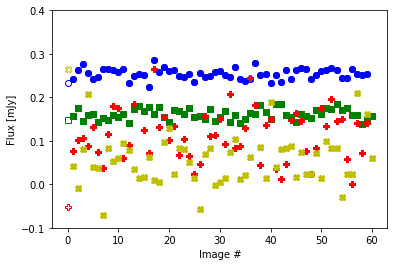

In [5]:
from astropy.stats import sigma_clip

aphot = QTable(names=("channel", "flux", "stddev", "mean_stddev", "SNR", "mean_bkg", "npts"),
               dtype=("int", "float", "float", "float", "float", "float", "int"),
               units=("", "mJy", "mJy", "mJy", "", "mJy", ""))

ptype = ['bo', 'gs', 'rP', 'yX']
chfiltered = []
np.set_printoptions(precision=5)
for i, sfluxes in enumerate(chsfluxes):
    plt.plot(np.arange(len(sfluxes)), sfluxes, ptype[i], fillstyle="none")

    filtered_data = sigma_clip(sfluxes, sigma=3, maxiters=5, masked=True)
    # make sure the 1st exposure is not used (issue with IRAC data)
    filtered_data.mask[0] = True
    chfiltered.append(filtered_data)
 
    # make and output an astropy table
    ophot = QTable()
    nfluxes = len(sfluxes)
    ophot["AOR"] = [aorid] * nfluxes
    ophot["channel"] = [i+1] * nfluxes
    ophot["pix_x"] = chsx[i]
    ophot["pix_y"] = chsy[i]
    ophot["flux"] = sfluxes * u.mJy
    ophot["pointgaincor"] = chscorfacs1[i]
    ophot["pixelphasecor"] = chscorfacs2[i]
    ophot["median_bkg"] = medbkgs[i] * u.mJy
    ophot["total_bkg"] = totbkgs[i] * u.mJy
    ophot["mask"] = filtered_data.mask
    ophot["filename"] = chsfiles[i]
    ophot.write(f"data/{sourcename}/{sourcename}_{aorid}_ch{i+1}_phot.dat", format="ipac", overwrite=True)

    plt.plot(np.arange(len(sfluxes)), filtered_data, ptype[i])

    mean = np.mean(filtered_data) * u.mJy
    stddev = np.std(filtered_data) * u.mJy
    stdmean = stddev / np.sqrt(len(filtered_data[~filtered_data.mask]))
    tbkgs = np.ma.masked_array(totbkgs[i], mask=filtered_data.mask)
    meanbkg = np.mean(tbkgs) * u.mJy
    print(f"ch{i+1}", mean, stddev, stdmean, mean/stdmean, meanbkg, len(filtered_data[~filtered_data.mask]))
    aphot.add_row([i+1, mean, stddev, stdmean, mean/stdmean, meanbkg, len(filtered_data[~filtered_data.mask])])

aphot.write(f"data/{sourcename}/{sourcename}_{aorid}_ave_phot.dat", format="ipac", overwrite=True)
               
plt.xlabel("Image #")
plt.ylabel("Flux [mJy]")
plt.ylim(-0.1, 0.4)

Display cutouts of each image showing the apertures used

Red sky annulii indicate measurements that were sigma clip rejected

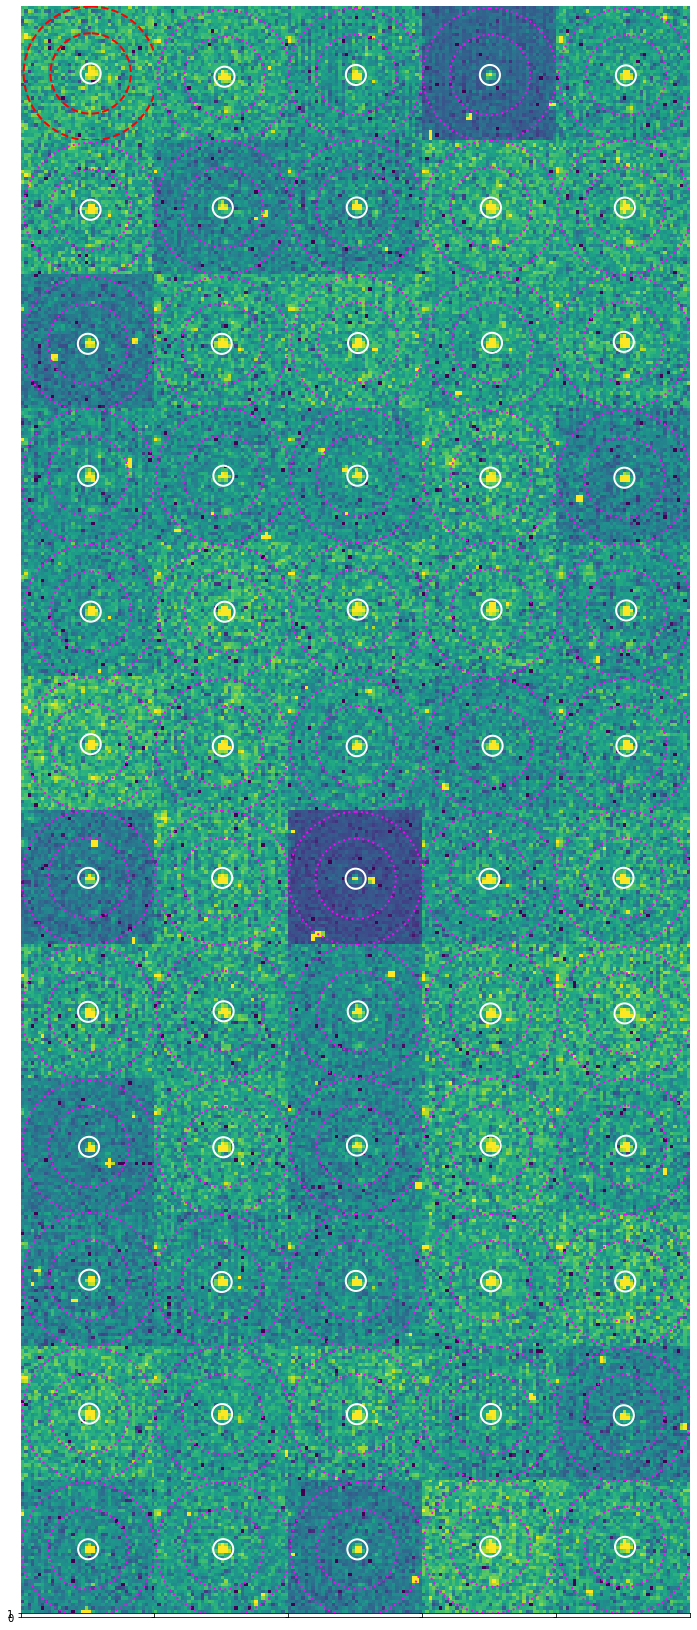

In [6]:
disp_subimages(allchfiles[0], chfiltered[0], aprads, new_center)

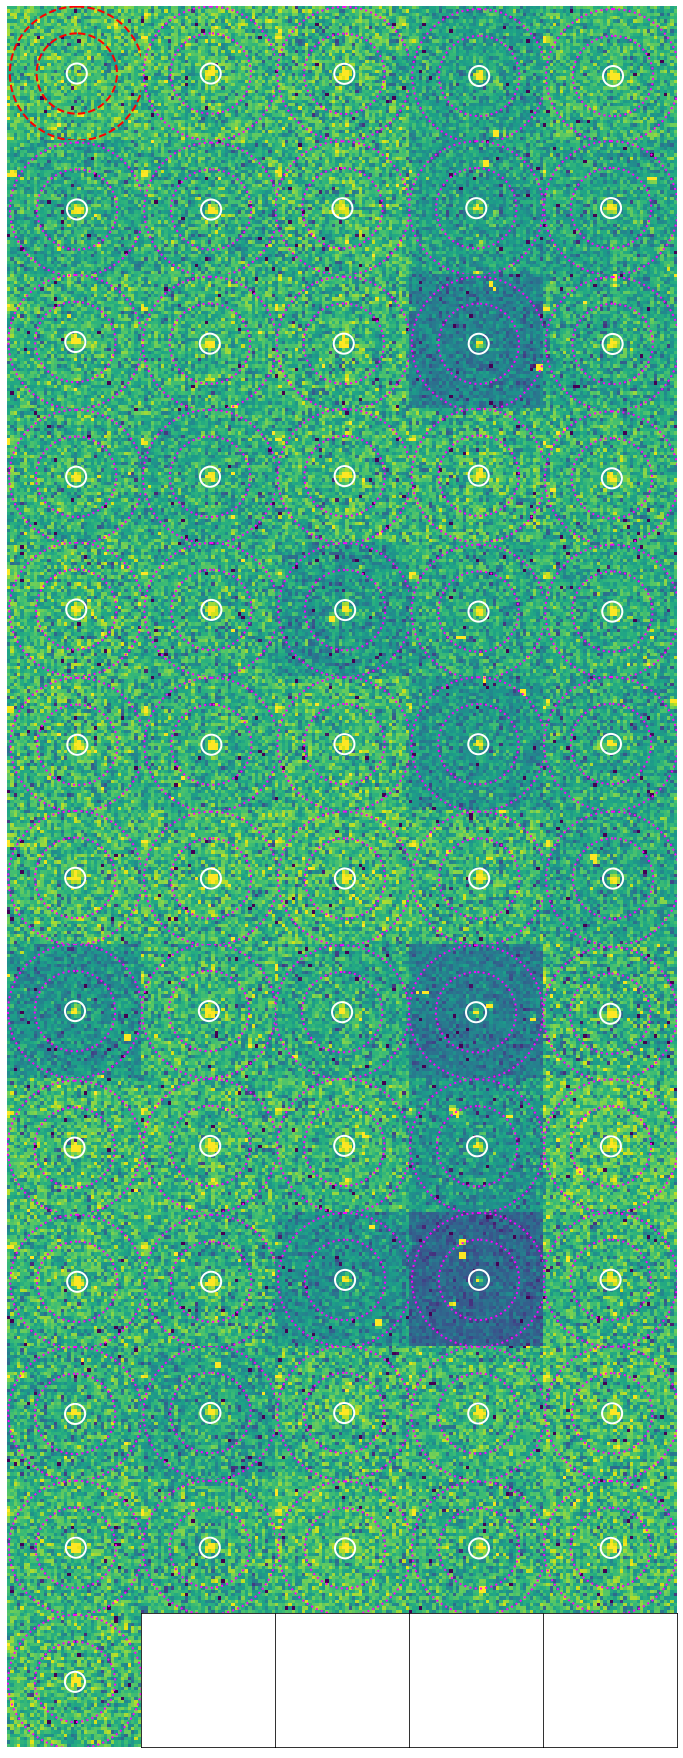

In [7]:
disp_subimages(allchfiles[1], chfiltered[1], aprads, new_center)

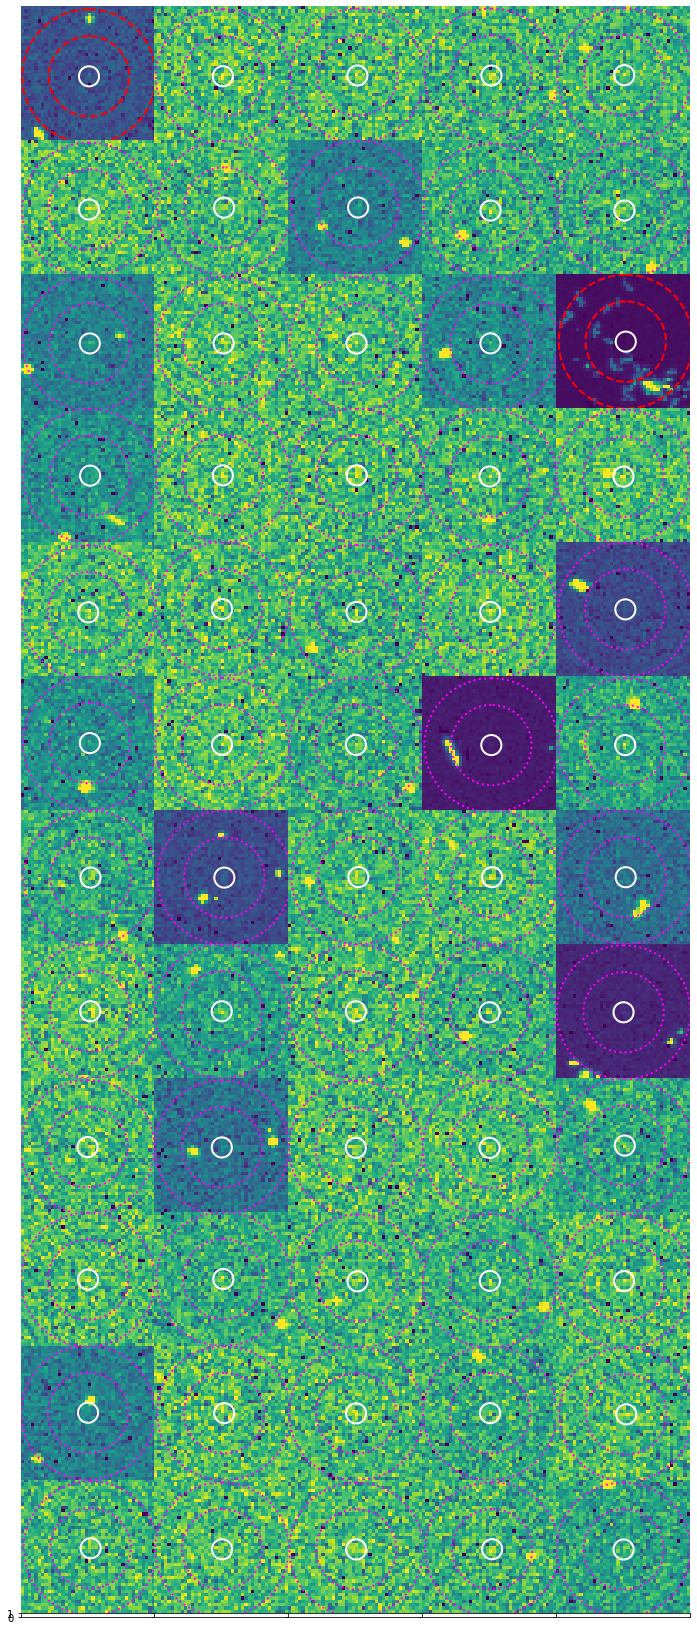

In [8]:
disp_subimages(allchfiles[2], chfiltered[2], aprads, new_center)

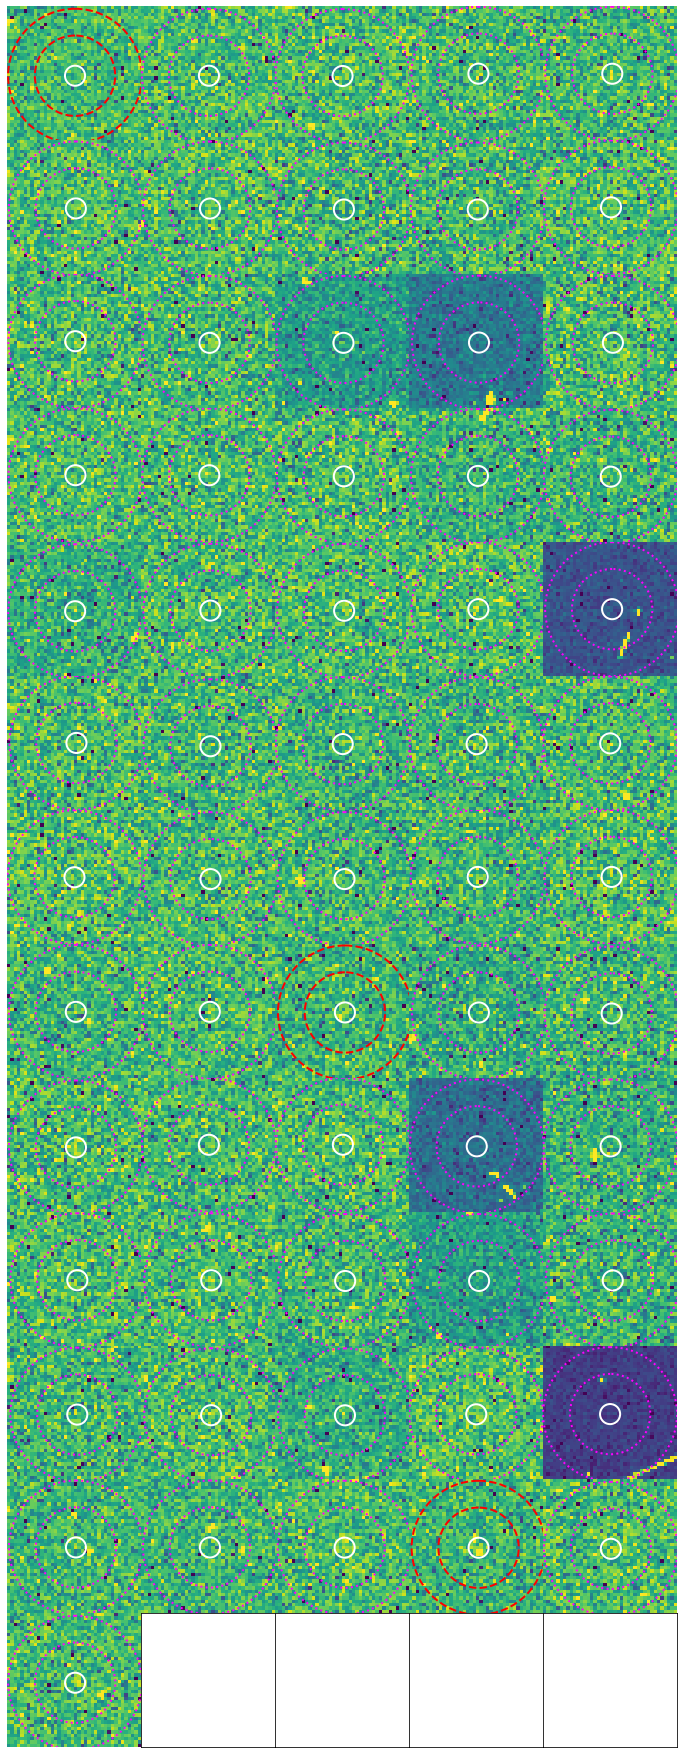

In [9]:
disp_subimages(allchfiles[3], chfiltered[3], aprads, new_center)